In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-07-03 04:32:51.535366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 04:32:51.535475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 04:32:51.699673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Paths to your training and validation CSV files and image folders
train_csv = '/kaggle/input/gi-track/Training.csv'
train_image_folder = '/kaggle/input/gi-track/All_Images/Training'

val_csv = '/kaggle/input/gi-track/Validation.csv'
val_image_folder = '/kaggle/input/gi-track/All_Images/Validation'

test_csv = '/kaggle/input/gi-track/Testing.csv'
test_image_folder = '/kaggle/input/gi-track/All_Images/Testing'

# Load training and validation data from CSV files
train_data = pd.read_csv(train_csv)
train_data['class'] = train_data['class'].astype(str)

val_data = pd.read_csv(val_csv)
val_data['class'] = val_data['class'].astype(str)

# Load test data CSV
test_data = pd.read_csv(test_csv)
test_data['class'] = test_data['class'].astype(str)

# Create an ImageDataGenerator for training data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  # Ensure class_mode is 'binary' and 'y_col' values are strings
)

# Flow from dataframe for validation
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=val_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',  # Ensure class_mode is 'binary' and 'y_col' values are strings
    shuffle=False
)

# Flow from dataframe for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',  # Ensure class_mode is 'binary' and 'y_col' values are strings
    shuffle=False
)

Found 2412 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.
Found 521 validated image filenames belonging to 2 classes.


In [3]:
# Load pretrained DenseNet121 model
weights_path = '/kaggle/input/densenet121/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = DenseNet121(weights=weights_path, include_top=False)
    
# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
    
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with validation
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stop]
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/76 ━━━━━━━━━━━━━━━━━━━━ 50:33 40s/step - accuracy: 0.4375 - loss: 0.9105

I0000 00:00:1719981253.385179     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719981253.448870     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/76 ━━━━━━━━━━━━━━━━━━━━ 19s 687ms/step - accuracy: 0.5736 - loss: 0.7539

W0000 00:00:1719981284.999461     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.6124 - loss: 0.6966

W0000 00:00:1719981301.728435     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719981320.447164     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 108s 897ms/step - accuracy: 0.6136 - loss: 0.6950 - val_accuracy: 0.8566 - val_loss: 0.3618
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.8262 - loss: 0.4048 - val_accuracy: 0.8852 - val_loss: 0.2990
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.8601 - loss: 0.3303 - val_accuracy: 0.9262 - val_loss: 0.2605
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.8881 - loss: 0.2891 - val_accuracy: 0.9221 - val_loss: 0.2387
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9087 - loss: 0.2496 - val_accuracy: 0.9344 - val_loss: 0.2293
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9196 - loss: 0.2297 - val_accuracy: 0.9221 - val_loss: 0.2180
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9085 - loss: 0.2355 - val_accuracy: 0.9344 - val_loss: 0.2079
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9274 - loss: 0.1987 - val_accuracy: 0.91

In [4]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, None,      │          0 │ conv2_block1_0_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, None,      │          0 │ pool1[0][0],      │
│ (Concatenate)       │ None, 96)         │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, None,      │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, None,      │          0 │ conv2_block2_0_b… │
│ (Activation)        │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, None,      │     12,288 │ conv2_block2_0_r

 Total params: 8,613,445 (32.86 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 1,050,628 (4.01 MB)

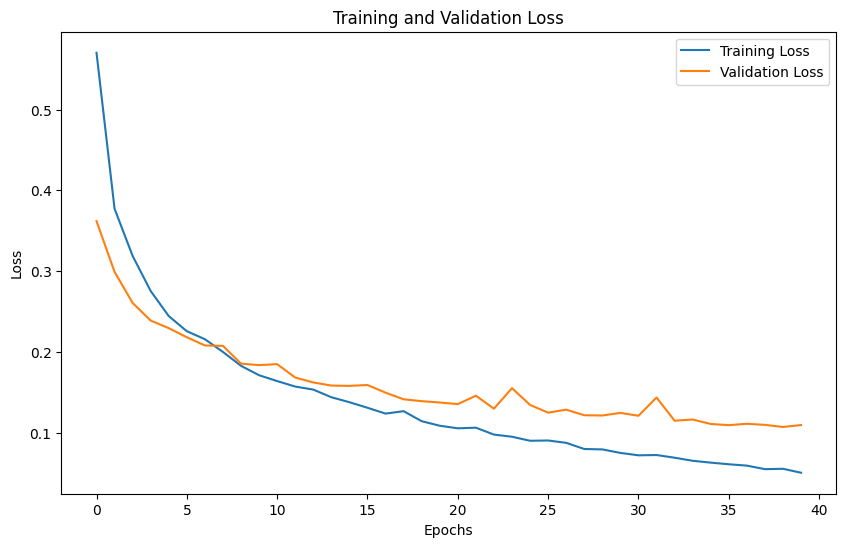

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
model.save('/kaggle/working/densenet121_model_Mix.h5')
print("Model saved successfully.")

Model saved successfully.


In [7]:
# Evaluate the model on the validation set (you can also evaluate on the test set similarly)
val_generator.reset()
val_pred_prob = model.predict(val_generator).ravel()
y_pred = (val_pred_prob > 0.5).astype(int)
y_true = val_generator.classes

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step 

W0000 00:00:1719981752.015120     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


W0000 00:00:1719981761.777838     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix
[[104   5]
 [  3 132]]
Classification Report
              precision    recall  f1-score   support

non-bleeding       0.97      0.95      0.96       109
    bleeding       0.96      0.98      0.97       135

    accuracy                           0.97       244
   macro avg       0.97      0.97      0.97       244
weighted avg       0.97      0.97      0.97       244


Class 0 - Non-Bleeding:
Sensitivity: 0.9541
Specificity: 0.9778
True Positive Rate: 0.9541
False Positive Rate: 0.0459

Class 1 - Bleeding:
Sensitivity: 0.9778
Specificity: 0.9541
True Positive Rate: 0.9778
False Positive Rate: 0.0222

ROC Curve Values:
FPR: [0.         0.         0.         0.00917431 0.00917431 0.01834862
 0.01834862 0.02752294 0.02752294 0.03669725 0.03669725 0.06422018
 0.06422018 0.11926606 0.11926606 0.22018349 0.22018349 1.        ]
TPR: [0.         0.00740741 0.81481481 0.81481481 0.86666667 0.86666667
 0.91111111 0.91111111 0.97037037 0.97037037 0.97777778 0.97777778
 0.9851851

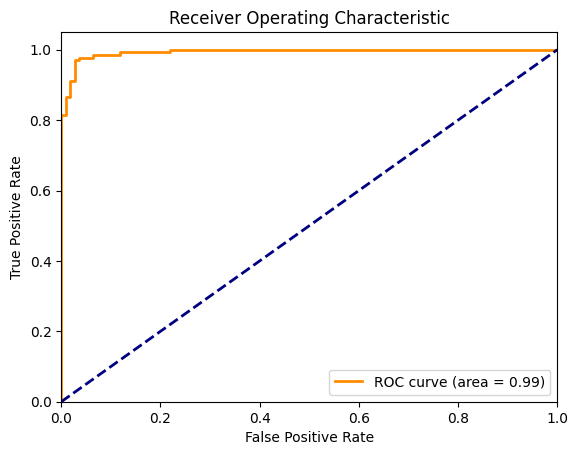

In [8]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['non-bleeding', 'bleeding'])
print('Classification Report')
print(cr)

# Calculate Sensitivity, Specificity, TPR, FPR for each class
tn, fp, fn, tp = cm.ravel()

# Class 0: Non-Bleeding
sensitivity_0 = tn / (tn + fp)
specificity_0 = tp / (tp + fn)
tpr_0 = sensitivity_0
fpr_0 = fp / (fp + tn)

# Class 1: Bleeding
sensitivity_1 = tp / (tp + fn)
specificity_1 = tn / (tn + fp)
tpr_1 = sensitivity_1
fpr_1 = fn / (fn + tp)

print(f"\nClass 0 - Non-Bleeding:")
print(f"Sensitivity: {sensitivity_0:.4f}")
print(f"Specificity: {specificity_0:.4f}")
print(f"True Positive Rate: {tpr_0:.4f}")
print(f"False Positive Rate: {fpr_0:.4f}")

print(f"\nClass 1 - Bleeding:")
print(f"Sensitivity: {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")
print(f"True Positive Rate: {tpr_1:.4f}")
print(f"False Positive Rate: {fpr_1:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, val_pred_prob)
roc_auc = auc(fpr, tpr)

# Store the ROC curve values for further use or plotting
roc_curve_values = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds,
    'roc_auc': roc_auc
}

print(f"\nROC Curve Values:")
print(f"FPR: {roc_curve_values['fpr']}")
print(f"TPR: {roc_curve_values['tpr']}")
print(f"Thresholds: {roc_curve_values['thresholds']}")
print(f"ROC AUC: {roc_curve_values['roc_auc']:.2f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step

W0000 00:00:1719981772.970079     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step 


W0000 00:00:1719981794.491108     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix
[[306  14]
 [  8 193]]
Classification Report
              precision    recall  f1-score   support

non-bleeding       0.97      0.96      0.97       320
    bleeding       0.93      0.96      0.95       201

    accuracy                           0.96       521
   macro avg       0.95      0.96      0.96       521
weighted avg       0.96      0.96      0.96       521


Class 0 - Non-Bleeding:
Sensitivity: 0.9563
Specificity: 0.9602
True Positive Rate: 0.9563
False Positive Rate: 0.0398

Class 1 - Bleeding:
Sensitivity: 0.9602
Specificity: 0.9563
True Positive Rate: 0.9602
False Positive Rate: 0.0437

ROC Curve Values:
FPR: [0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.003125 0.003125 0.003125 0.003125 0.00625  0.00625  0.009375
 0.009375 0.0125   0.0125   0.01875  0.01875  0.021875 0.021875 0.025
 0.025    0.028125 0.028125 0.04375  0.04375  0.0625   0.0625   0.065625
 0.065625 0.08125  0.08125  0.1      0.1      0.859375 0.865625 1.  

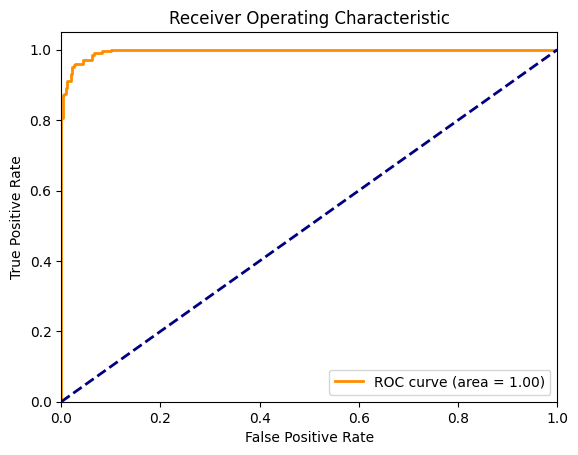

In [9]:
# Load the pretrained model
model_path = '/kaggle/working/densenet121_model_Mix.h5'
model = load_model(model_path)  # Adjust the filename as per your saved model

# Evaluate the model on the test set
test_generator.reset()
y_pred_prob = model.predict(test_generator).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['non-bleeding', 'bleeding'])
print('Classification Report')
print(cr)

# Calculate Sensitivity, Specificity, TPR, FPR for each class
tn, fp, fn, tp = cm.ravel()

# Class 0: Non-Bleeding
sensitivity_0 = tn / (tn + fp)
specificity_0 = tp / (tp + fn)
tpr_0 = sensitivity_0
fpr_0 = fn / (fn + tp)

# Class 1: Bleeding
sensitivity_1 = tp / (tp + fn)
specificity_1 = tn / (tn + fp)
tpr_1 = sensitivity_1
fpr_1 = fp / (fp + tn)

print(f"\nClass 0 - Non-Bleeding:")
print(f"Sensitivity: {sensitivity_0:.4f}")
print(f"Specificity: {specificity_0:.4f}")
print(f"True Positive Rate: {tpr_0:.4f}")
print(f"False Positive Rate: {fpr_0:.4f}")

print(f"\nClass 1 - Bleeding:")
print(f"Sensitivity: {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")
print(f"True Positive Rate: {tpr_1:.4f}")
print(f"False Positive Rate: {fpr_1:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)  # Use y_pred_prob here
roc_auc = auc(fpr, tpr)

# Store the ROC curve values for further use or plotting
roc_curve_values = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds,
    'roc_auc': roc_auc
}

print(f"\nROC Curve Values:")
print(f"FPR: {roc_curve_values['fpr']}")
print(f"TPR: {roc_curve_values['tpr']}")
print(f"Thresholds: {roc_curve_values['thresholds']}")
print(f"ROC AUC: {roc_curve_values['roc_auc']:.2f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()